### 1. Problem statement
 - We are given Google stock price from 01/2012 to 12/2017. 
 - The task is to predict the trend of the stock price for 01-06 2018. 
 - The goal is to predict the **close price** of the given date from test data

### 2. Import Library

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### 3. Data review & processing

#### 3.1 Read data

In [2]:
stock_data = pd.read_csv("../Google_Stock_Price_Train.csv")
test_data = pd.read_csv("../Google_Stock_Price_Test.csv")

### 3.2 Data Exploration

In [3]:
stock_data.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
stock_data.tail()

,Date,Open,High,Low,Close,Volume
1504,22/12/2017,1061.109985,1064.199951,1059.439941,1060.119995,755100
1505,26/12/2017,1058.069946,1060.119995,1050.199951,1056.73999,760600
1506,27/12/2017,1057.390015,1058.369995,1048.050049,1049.369995,1271900
1507,28/12/2017,1051.599976,1054.750000,1044.770020,1048.140015,837100
1508,29/12/2017,1046.719971,1049.699951,1044.900024,1046.400024,887500


In [5]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 6 columns):
Date      1509 non-null object
Open      1509 non-null float64
High      1509 non-null float64
Low       1509 non-null float64
Close     1509 non-null object
Volume    1509 non-null object
dtypes: float64(3), object(3)
memory usage: 70.8+ KB


From here we can see our data has 6 columns:
* **Date**: The date of recorded data
* **Open**: The price when stock market open
* **High**: The highest price price of date
* **Low**: The lowest price point of date
* **Volumn**: Total Sale of stock on that date

In [6]:
stock_data['Close'] = stock_data['Close'].apply(lambda x: float(x.replace(',', '')))
stock_data['Volume'] = stock_data['Volume'].apply(lambda x: float(x.replace(',', '')))

In [7]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 6 columns):
Date      1509 non-null object
Open      1509 non-null float64
High      1509 non-null float64
Low       1509 non-null float64
Close     1509 non-null float64
Volume    1509 non-null float64
dtypes: float64(5), object(1)
memory usage: 70.8+ KB


In [8]:
stock_data.sample(5)

,Date,Open,High,Low,Close,Volume
160,8/21/2012,335.300000,337.73000,329.850000,667.680000,4461000.0
739,12/10/2014,531.620000,534.86000,524.120000,524.620000,1712200.0
1171,8/29/2016,768.740000,774.99000,766.610000,772.150000,847600.0
259,1/15/2013,358.320000,366.13000,354.720000,722.950000,7884700.0
1385,06/07/2017,904.119995,914.94397,899.700012,906.690002,1424500.0


### 3.3 Virtaulization

### 3.3.1 Plot the Open price

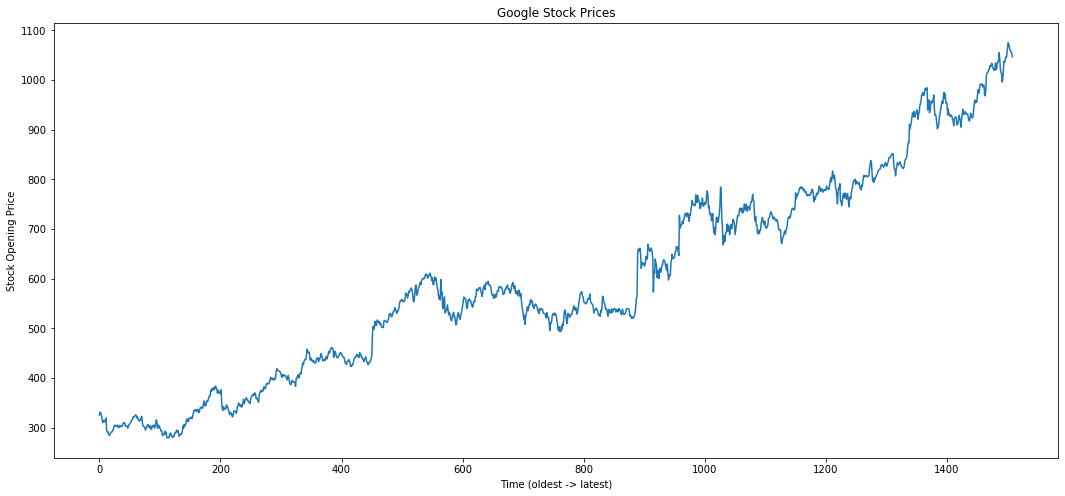

In [9]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Open'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Opening Price")
plt.show()

### 3.3.2 Plot the High price

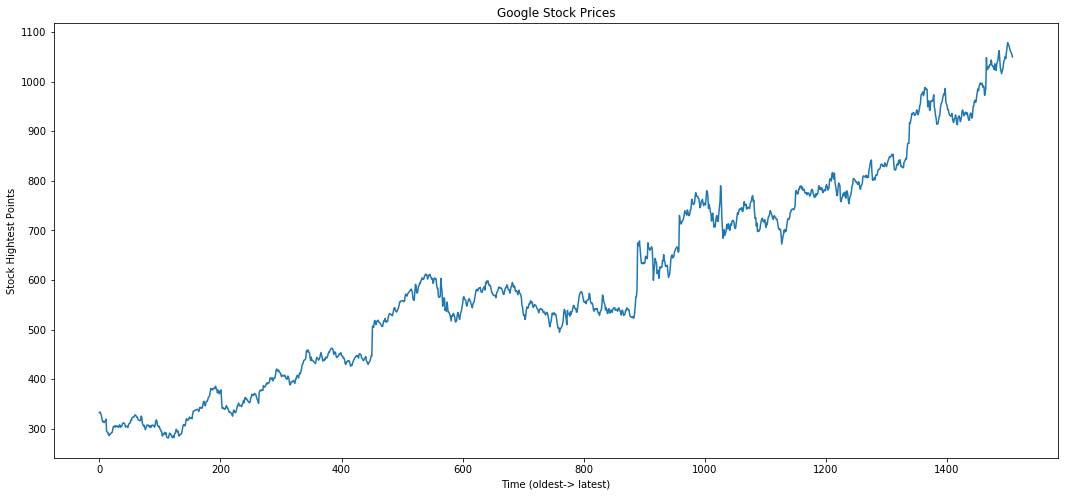

In [10]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['High'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest-> latest)")
plt.ylabel("Stock Hightest Points")
plt.show()

### 3.3.3 Plot the Low price

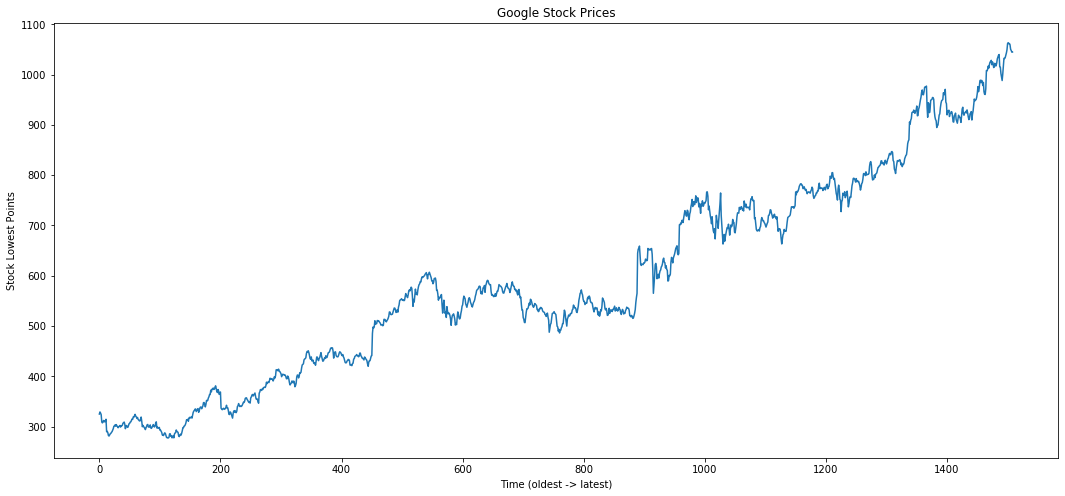

In [11]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Low'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Lowest Points")
plt.show()

### 3.4 Select feature
 - Select Open, High, Low, Volumn and Close columns. 
 - Put close column to the last one as the target. 

In [12]:
input_feature = stock_data[['Open', 'High', 'Low', 'Volume', 'Close']]
input_data = input_feature.values

In [13]:
input_data.shape

(1509, 5)

### 3.5 Normalize data
make data between 0 and 1

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
# input_data[:,:] = scaler.fit_transform(input_data[:,:])
input_data = scaler.fit_transform(input_data)

In [15]:
input_data

array([[0.05794644, 0.06474513, 0.06072514, 0.29525831, 0.23757287],
       [0.0655085 , 0.06604957, 0.06595195, 0.22993592, 0.24151427],
       [0.06369963, 0.06213626, 0.06316686, 0.26361233, 0.22878051],
       ...,
       [0.97762796, 0.9747642 , 0.98028818, 0.05062074, 0.76922122],
       [0.97035477, 0.97022377, 0.97611686, 0.03320785, 0.76752617],
       [0.96422472, 0.96388968, 0.97628219, 0.03522627, 0.76512827]])

In [16]:
input_data.shape

(1509, 5)

### 3.6 Create data

In [17]:
lookback = 60
total_size = len(stock_data)

In [18]:
X=[]
y=[]
for i in range(0, total_size-lookback): # loop data set with margin 50 as we use 50 days data for prediction
    t=[]
    for j in range(0, lookback): # loop for 50 days
        current_index = i+j
        t.append(input_data[current_index, :]) # get data margin from 50 days with marging i
    X.append(t)
    y.append(input_data[lookback+i, 4])

In [19]:
len(X), len(y)

(1449, 1449)

### 3.7 Split train, validate and test data

* We will get last 120 days for testing (predict). 
* 15% of the rest for validation
* 85% of the rest for training

In [20]:
X, y= np.array(X), np.array(y)
X.shape, y.shape

((1449, 60, 5), (1449,))

In [21]:
test_size = 120 

X_test = X[-test_size:]
Y_test = y[-test_size:]

X_rest = X[: -test_size]
y_rest = y[: -test_size]

X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size = 0.15, random_state = 101)


### 3.8 Reshape data

In [22]:
X_train = X_train.reshape(X_train.shape[0], lookback, 5)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 5)
X_test = X_test.reshape(X_test.shape[0], lookback, 5)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1129, 60, 5)
(200, 60, 5)
(120, 60, 5)


### 4. Model creat & fit

### 4.1 Create model

In [23]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

#### Callbacks
* **EarlyStoping**: It will stop the traning if score of model didn't increase. This prevent model from overfitting. We are to set max in 10 epoches if it didn't increase then we will stop the training
* **ReduceLROnPlateau**: Use for reduce the learning rate. In 3 steps the score didn't increase we will reduce the learning rate to improve the training
* **ModelCheckpoint**: Use for save model only when the score increased

In [24]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [25]:
# regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

### 4.2 Fit Model

In [26]:
regressor.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.0018
Epoch 00001: val_loss improved from inf to 0.01191, saving model to model.h5
142/142 [==============================] - 14s 100ms/step - loss: 0.0175 - accuracy: 0.0018 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.0018
Epoch 00002: val_loss improved from 0.01191 to 0.00624, saving model to model.h5
142/142 [==============================] - 12s 84ms/step - loss: 0.0107 - accuracy: 0.0018 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.0018
Epoch 00003: val_loss improved from 0.00624 to 0.00438, saving model to model.h5
142/142 [==============================] - 12s 85ms/step - loss: 0.0078 - accuracy: 0.0018 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 4/100
142/142 [==============================] - ETA

Epoch 28/100
142/142 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.0018
Epoch 00028: val_loss improved from 0.00293 to 0.00292, saving model to model.h5
142/142 [==============================] - 17s 117ms/step - loss: 0.0026 - accuracy: 0.0018 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 29/100
142/142 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.0018
Epoch 00029: val_loss did not improve from 0.00292
142/142 [==============================] - 16s 111ms/step - loss: 0.0024 - accuracy: 0.0018 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 30/100
142/142 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.0018
Epoch 00030: val_loss improved from 0.00292 to 0.00289, saving model to model.h5
142/142 [==============================] - 15s 108ms/step - loss: 0.0030 - accuracy: 0.0018 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 31/100
142/142 [==============================] - ETA: 0s - loss: 0.0027 

Epoch 56/100
142/142 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.0018
Epoch 00056: val_loss did not improve from 0.00282
142/142 [==============================] - 11s 78ms/step - loss: 0.0027 - accuracy: 0.0018 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 57/100
142/142 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.0018
Epoch 00057: val_loss did not improve from 0.00282
142/142 [==============================] - 11s 78ms/step - loss: 0.0024 - accuracy: 0.0018 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 58/100
142/142 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.0018
Epoch 00058: val_loss did not improve from 0.00282
142/142 [==============================] - 10s 73ms/step - loss: 0.0024 - accuracy: 0.0018 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 59/100
142/142 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.0018
Epoch 00059: val_loss did not improve from 0

### 5. Evaluate model

In [27]:
predicted_value = regressor.predict(X_test)

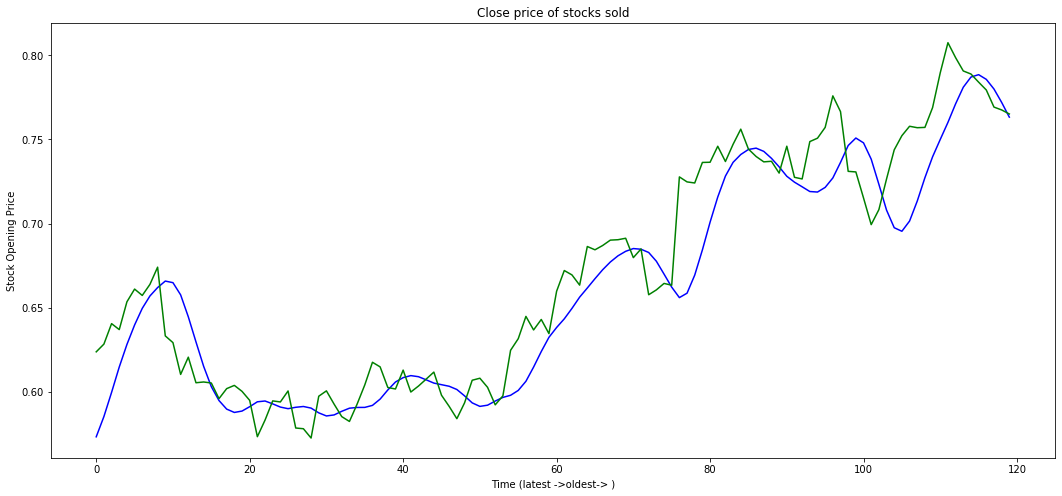

In [29]:
plt.figure(figsize=(18, 8))
plt.plot(predicted_value, color= 'blue')
plt.plot(Y_test, color='green')
plt.title("Close price of stocks sold")
plt.xlabel("Time (latest ->oldest-> )")
plt.ylabel("Stock Opening Price")
plt.show()